# Create netcdf from cdp data

In [31]:
# imports from packages
import pandas as pd
import xarray as xr
import numpy as np
import warnings


# imports from files
import functions
import re
#import read_lwc
import read_nav
import read_cip_nc
import numb_conc
import read_seaice

import sys # to test parts of code with sys.exit()
import glob # allows for wildcards in filemanagement
import os #get a list of all directories/files
    

# surpress UserWarning connected to timezoneless np.datetime
warnings.filterwarnings("ignore", message="no explicit representation of timezones available for np.datetime64")
# surpress UserWrning connected to boolean series indexing (creating dataframe with null values)
warnings.filterwarnings("ignore", message="Boolean Series key will be reindexed to match DataFrame index.")


In [32]:
# read nav
nav_df, nav_stats_dict, extra_info= read_nav.read_nav() # extra_info includes limits for the plots (campaign_cood_limits) and extra landing and takeoff times

In [ ]:
#TODO: This is from the read_cdp file. that file needs to be updated!!!!
# Local disk path of data:
main_path = '../2022-islas/' # directory with flight data
pads_path = '/microphy/pads/' # path to pads (CIP and CDP data)
cdp_file_struct = '/02CDP*.csv' # structure of cdp file names
drop_flights = ['as220005','as220006'] # flights to drop, (if not all are to be analysed 5 and 6 is in france)

flights = [
    f for f in os.listdir(main_path) if os.path.isdir(os.path.join(main_path, f))
]

# remove flights to drop using listcomprehension
flights = [i for i in flights if i not in drop_flights]

islas_cdp_df = []  # empty list for appending all data to one structure
meta_dict = {} # initiate dictionary for storing metadata (to generate netcdfs)

print('----Reading CDP files:')
    
for flight in flights:
    flight_dict = {} # initiate inner dict for flight
      
    # ---- Get CDP data    
    # path to CDP data
    path_in = main_path + flight + pads_path
    
    # Get a list of all the CDPfiles in the directory (also look in subdirectories)
    filelist = glob.glob(path_in + '**' + cdp_file_struct, recursive=True)

    #in each directory there is a CDP-csv file
    for i,file in enumerate(filelist):
        print('Reading: ' + file) 
        # reading in csv data without metadata    
        cdp_list = functions.read_chunky_csv(file)
        
        # --- Get data information from 2th chunk. Turn this into a dataframe:
        data = cdp_list[2]
        data.pop(0) # remove separator line
        header = data.pop(0) #get header
        cdp_df = pd.DataFrame(data) # turn into dataframe
        cdp_df = cdp_df.astype(float) # change from string to float
        cdp_df.columns = header #add header information to df
        cdp_df["safireid"]=flight # add flight information
        
        # transform UTC Seconds to datetime, add to time
        date_temp= functions.resolve_date(cdp_df['Year'], cdp_df['Day of Year'])
        sec_temp = cdp_df['UTC Seconds'].apply(lambda x: pd.to_timedelta(x, unit='s')) #turn utc seconds since midnight into datetime object
        cdp_df['time'] = date_temp + sec_temp # add date to the seconds since midnight
        
        
        #---- Get metadata from 0th item in cdp_list
        meta = cdp_list[0]
        # flatten the list
        cdp_meta = [item[0] if len(item) == 1 else ' '.join(item) for item in meta]
        cdp_meta.pop(0) # remove first item of list [Instrument2]
        
        # split list based on conditions (including "Channel" or "<30>" and the rest)
        sub_ch = 'Channels'
        sub_bin = '<30>'
            
        chan_list = [i for i in cdp_meta if sub_ch in i] # list of all items with 'Channel'
        bin_list = [i for i in cdp_meta if sub_bin in i] # list of all items with '<30>'
        
        meta_bin_list = list(set(cdp_meta).difference(chan_list)) # remove chan_list from cdp_list
        meta_list = list(set(meta_bin_list).difference(bin_list)) # remove bin_list from the resulting list
        
        # Turn metadata list into dataframe, clean up and separate variable from value 
        meta_df=pd.DataFrame(meta_list, columns=['Metadata'])
        meta_df['Value'] = meta_df['Metadata'].apply(lambda x: x.split('=')[1].strip())
        meta_df['Metadata'] = meta_df['Metadata'].apply(lambda x: x.split('=')[0].strip())
        
        # Fix the sample time and sample volume metadata for later use
        # sample area from meta information and given in mm^2 readjust to m by dividing with 10⁶
        sa = float(meta_df.loc[meta_df['Metadata'] == 'Sample Area (mm^2)', 'Value'].iloc[0]) /(1000*1000)
        st_text = meta_df.loc[meta_df['Metadata'] == 'Sample Time', 'Value'].iloc[0] 
        # find seconds from first number in text
        pattern = r'\d+'
        match = re.search(pattern, st_text)
        if match:
            st = int(match.group())
                
        # Turn bin_list (list of strings) into dataframe of bin information
        # Take entry that includes size or thres, remove the parts of the string that is not values, turn into list
        size_list = [i for i in bin_list if 'Size' in i][0].replace("Sizes=<30>","",1).split(" ")
        thr_list = [i for i in bin_list if 'Thres' in i][0].replace("Thresholds=<30>","",1).split(" ")
        # Make list of lower edges
        # lower edge of the first bin is in the metadata, the rest is the same as the size list -last entry
        bin1min = meta_df.loc[meta_df['Metadata']=='Bin 1 Lower Thresh.','Value'].iloc[0] # get the value of the lower bin size treshold
        size_min_list = list(bin1min)+ size_list # add the bin1min to the top of the list
        size_min_list.pop() # remove the last item of the list
        # generate bin number based on lenght of size_list and thr_list
        if len(size_list)==len(thr_list):
            bin_list = list(range(1,len(size_list)+1, 1))
        else:
            print('Warning: size_list and thr_list not of equal lenght')
        
        # turn the three lists into dataframe of integers
        bins_df = pd.DataFrame({'CDP_Bin': bin_list, 'Size (microns)': size_list,'Min size': size_min_list, 'Threshold': thr_list}).astype('int64').set_index('CDP_Bin')
        # calculate the bind width for each bin (for later normalization of values)
        bins_df['Width']=bins_df['Size (microns)'] - bins_df['Min size']
           
            
        # --- get pads information from 1st item in cdp_list
        pads_info_df = pd.DataFrame(cdp_list[1], columns=['Info'])
        # clean up and separate variable from unit 
        pads_info_df['Value'] = pads_info_df['Info'].apply(lambda x: x.split('=')[1].strip())
        pads_info_df['Info'] = pads_info_df['Info'].apply(lambda x: x.split('=')[0].strip())

        # adding NAV information to the cdp data by merging on nearest UTC Seconds. 
        flight_nav_df = nav_df[nav_df['safireid']==flight]

        cdp_nav_df = pd.merge_asof(cdp_df, flight_nav_df[['UTC Seconds','TAS (m/s)','Latitude (degree)', 'Longitude (degree)','Altitude (meter)', 'flightid']] , on = 'UTC Seconds', direction = 'nearest')
        # drop any duplicates of time (from errors in nav)
        cdp_nav_df = cdp_nav_df[~cdp_nav_df['time'].duplicated(keep='first')]

        #extract only filename from file
        filename = file.split('/')[-1]
        flight_dict[i]={'filename':filename,'islasids':cdp_nav_df['flightid'].unique(), 'pads info': cdp_list[1], 'instrument info': meta_df, 'channel info':chan_list}
        islas_cdp_df.append(cdp_nav_df) # append list with the new dataframe
    meta_dict[flight] = flight_dict

# concatenate all the flight dataframes in the list to a new dataframe containing all flights
islas_cdp_df = pd.concat(islas_cdp_df)

# Clean up unnnecessary columns: Spare
islas_cdp_df = islas_cdp_df.loc[:,~islas_cdp_df.columns.str.startswith('Spare')]

# --- Data corrections

# adjust time variables to have a complete datetime object 'time'

# -- CDP: adjust bulk parameters for TAS
# calculate TAS correction factor for each timestep
# (aircraft TAS - 13%)/PAS from probe calculations from Frey(2011) % take this out for now
#islas_cdp_df['TAS probe reduction (m/s)'] = 0.87*islas_cdp_df['TAS (m/s)'] # reduce TAS due to airflow (-13%) # code for doing the reduction
islas_cdp_df['TAS correction factor'] = islas_cdp_df['Applied PAS (m/s)']/islas_cdp_df['TAS (m/s)'] # code without reduction

# adjust the Numb conc and the LWC parameters with the correction factor
# (MVD and ED is not dependent on TAS)
islas_cdp_df['Number Conc corr (#/cm^3)'] = islas_cdp_df['Number Conc (#/cm^3)']*islas_cdp_df['TAS correction factor']
islas_cdp_df['LWC corr (g/m^3)'] = islas_cdp_df['LWC (g/m^3)']*islas_cdp_df['TAS correction factor']


#calculate the sample volume (sample area SA * TAS redused * sample time (1 sek))
islas_cdp_df['SV (m^3)'] = sa * islas_cdp_df['TAS (m/s)'] * st


# Get variable information from header of dataframe
var_df = pd.DataFrame(islas_cdp_df.columns[islas_cdp_df.columns.str.endswith(')')], columns=['Variable'])
var_df['unit'] = var_df['Variable'].apply(lambda x: x.split('(')[1].strip())
var_df['Variable'] = var_df['Variable'].apply(lambda x: x.split('(')[0].strip())
var_df = var_df.replace(r'\)','',regex=True) # removing remaining ] in units
    

----Reading CDP files:
Reading: ../2022-islas/as220014/microphy/pads/20220403071511/02CDP 20220403071511.csv
Reading: ../2022-islas/as220009/microphy/pads/20220326080106/02CDP 20220326080106.csv
Reading: ../2022-islas/as220010/microphy/pads/02CDP 20220326133751.csv
Reading: ../2022-islas/as220007/microphy/pads/20220324080247/02CDP 20220322105458.csv
Reading: ../2022-islas/as220015/microphy/pads/20220403123534/02CDP 20220403123534.csv
Reading: ../2022-islas/as220008/microphy/pads/20220324080247/02CDP 20220324080247.csv
Reading: ../2022-islas/as220008/microphy/pads/20220324113123/02CDP 20220324113123.csv
Reading: ../2022-islas/as220008/microphy/pads/20220324130909/02CDP 20220324130909.csv
Reading: ../2022-islas/as220013/microphy/pads/20220331093304/02CDP 20220331093304.csv
Reading: ../2022-islas/as220011/microphy/pads/02CDP 20220329081432.csv
Reading: ../2022-islas/as220012/microphy/pads/20220330135853/02CDP 20220330135853.csv
Reading: ../2022-islas/as220012/microphy/pads/20220330134834/

In [80]:
islas_cdp_df

,End Seconds,Day of Year,Year,Status,DOF Reject Counts,Avg Transit Reject,Avg Transit Time,DT Bandwidth,Dynamic Threshold,ADC Overflow,...,time,TAS (m/s),Latitude (degree),Longitude (degree),Altitude (meter),flightid,TAS correction factor,Number Conc corr (#/cm^3),LWC corr (g/m^3),SV (m^3)
0,26112.347656,93.0,2022.0,1.0,3.0,393322.0,0.0,5.0,90.0,0.0,...,2022-04-03 07:15:12.134766,66.301689,67.839218,20.364349,751.648315,IS22-10,1.508257,0.000000,0.000000,0.000018
1,26113.349609,93.0,2022.0,1.0,2.0,393322.0,0.0,5.0,90.0,0.0,...,2022-04-03 07:15:13.142578,66.377342,67.839699,20.365078,760.348206,IS22-10,1.506538,0.000000,0.000000,0.000018
2,26114.343750,93.0,2022.0,1.0,2.0,393322.0,0.0,5.0,90.0,0.0,...,2022-04-03 07:15:14.136719,66.187317,67.840172,20.365801,769.375671,IS22-10,1.510863,0.000000,0.000000,0.000018
3,26115.347656,93.0,2022.0,1.0,2.0,393322.0,0.0,5.0,90.0,0.0,...,2022-04-03 07:15:15.132812,65.619041,67.840645,20.366514,778.687073,IS22-10,1.523948,0.000000,0.000000,0.000018
4,26116.349609,93.0,2022.0,1.0,2.0,393322.0,0.0,5.0,90.0,0.0,...,2022-04-03 07:15:16.132812,65.225281,67.841110,20.367222,788.348328,IS22-10,1.533148,0.000000,0.000000,0.000018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
585,50300.183594,89.0,2022.0,1.0,1.0,458860.0,0.0,4.0,94.0,0.0,...,2022-03-30 13:58:19.824219,63.535732,67.824181,20.340767,589.225830,IS22-08,1.573917,0.000000,0.000000,0.000017
586,50301.183594,89.0,2022.0,1.0,0.0,458860.0,69.0,5.0,94.0,0.0,...,2022-03-30 13:58:20.835937,63.468735,67.824554,20.341433,596.434082,IS22-08,1.575579,0.058572,0.000005,0.000017
587,50302.183594,89.0,2022.0,1.0,1.0,393323.0,53.0,4.0,94.0,0.0,...,2022-03-30 13:58:21.828125,63.088215,67.824936,20.342096,602.989929,IS22-08,1.585082,0.058925,0.000001,0.000017
588,50303.183594,89.0,2022.0,1.0,3.0,393323.0,0.0,5.0,94.0,0.0,...,2022-03-30 13:58:22.828125,62.794670,67.825310,20.342762,609.450562,IS22-08,1.592492,0.000000,0.000000,0.000017


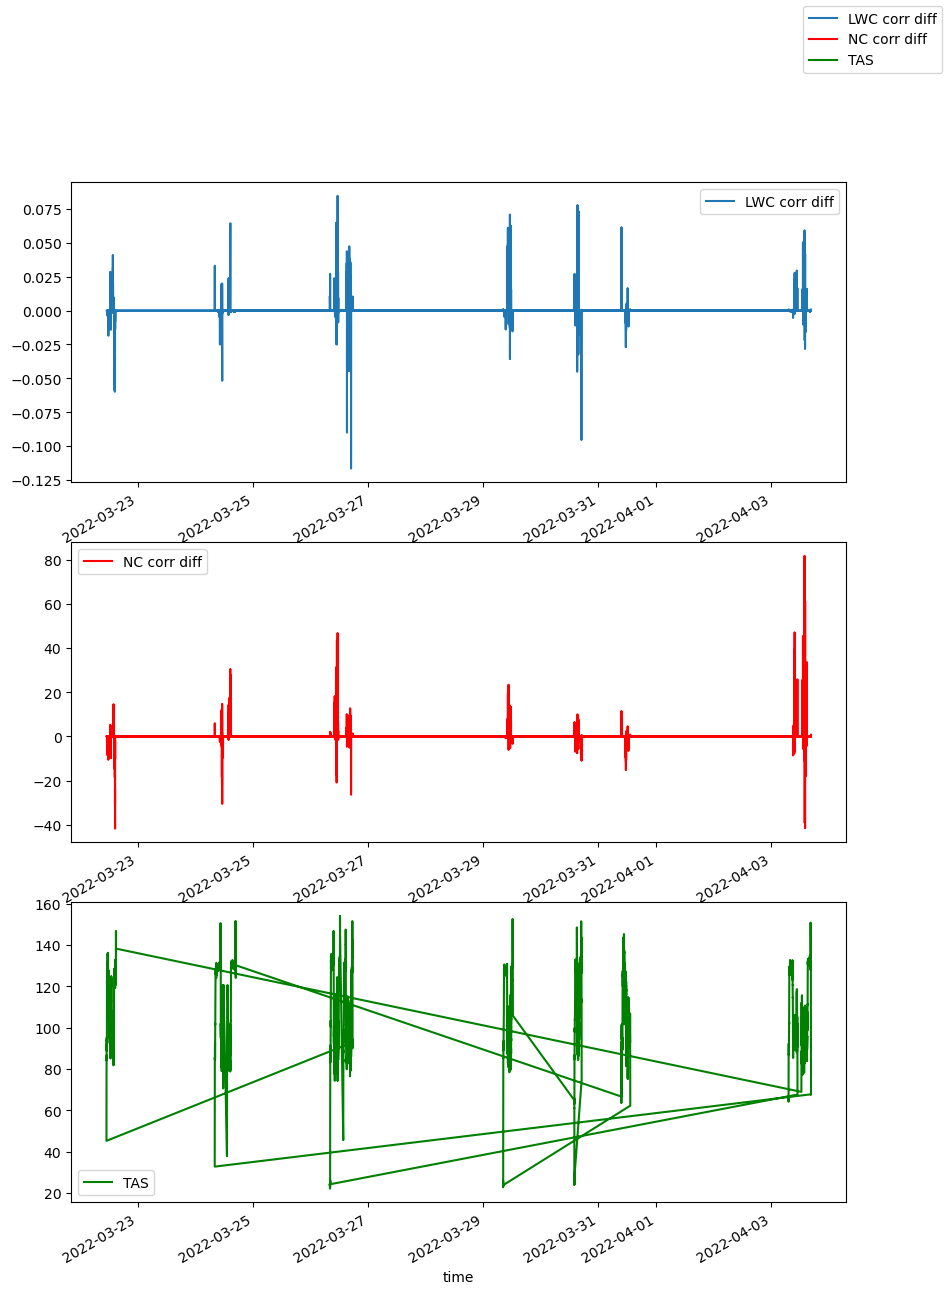

In [ ]:
# plot LWC and NC differences vs tas and pas differences
import matplotlib.pyplot as plt

# --- Set up figure
fig, ax = plt.subplots(3,1, figsize=(10,15))


# calculate differences
islas_cdp_df['LWC_diff'] = islas_cdp_df['LWC corr (g/m^3)']-islas_cdp_df['LWC (g/m^3)']
islas_cdp_df['NC_diff'] = islas_cdp_df['Number Conc corr (#/cm^3)']-islas_cdp_df['Number Conc (#/cm^3)']


#select single flight
test = islas_cdp_df[islas_cdp_df['flightid']=='IS22-10']

islas_cdp_df.plot(kind='line', x='time',y='LWC_diff',ax=ax[0], label='LWC corr diff')
islas_cdp_df.plot(kind='line', x='time',y='NC_diff',ax=ax[1],c='r', label='NC corr diff')
islas_cdp_df.plot(kind='line', x='time',y='TAS (m/s)',ax=ax[2],c='g', label='TAS')


fig.legend()
#plt.show

In [ ]:
islas_cdp_df[islas_cdp_df['LWC corr (g/m^3)']>0.01][['time', 'LWC corr (g/m^3)']]

In [51]:
path_store = '../Results_2022-islas/Processed/CDP_processed/' # where to store the netcdfs

# Dictionary to hold counts of second level entries
second_level_counts = {}

for key in meta_dict:
    # Count entries in the second level for each first-level key
    second_level_counts[key] = len(meta_dict[key])
    if second_level_counts[key]==1:
        # Keep metadata as is and extract all information for the given key and islasid
        source_files = [meta_dict[key][0]['filename']]
        chan_list = meta_dict[key][0]['channel info']
        meta_df = meta_dict[key][0]['instrument info']
        cdp_list = meta_dict[key][0]['pads info']
        flightid = meta_dict[key][0]['islasids'][0]
        # filter dataframe with all data on flightid
        cdp_nav_flight_df = cdp_nav_df[cdp_nav_df['flightid']==flightid]
        # create netcdf for this flight:
        print(f'creating netcdf for flight {flightid}')
        ds = functions.cdp_df_to_netcdf(cdp_nav_flight_df, cdp_list, meta_df, chan_list, bins_df, source_files, path_store)
        print('-----')                
    else:
        # if more than one file, check and consolidate metadata
        # first: check if the files have different islasid
        unique_ids=functions.find_unique_listkey(meta_dict[key],'islasids')
        
        if len(unique_ids)==1: # if all files have the same islasid
            # TODO: if all the islasids from the dict is the same, check if the metadata is the same
            # meta_dict['as220012'][0]['channel info']==meta_dict['as220012'][1]['channel info']
            # For now: use the first entry as the default
            source_files = [entry['filename'] for entry in meta_dict[key].values()] # get all filenames by list comprehension
            chan_list = meta_dict[key][0]['channel info']
            meta_df = meta_dict[key][0]['instrument info']
            cdp_df = meta_dict[key][0]['pads info']
            flightid = meta_dict[key][0]['islasids'][0]
            cdp_nav_flight_df = cdp_nav_df[cdp_nav_df['flightid']==flightid]
            # create netcdf for this flight:
            print(f'creating netcdf for flight {flightid}')
            ds = functions.cdp_df_to_netcdf(cdp_nav_flight_df, cdp_list, meta_df, chan_list, bins_df, source_files, path_store)
        else:
            # separate by islasid: Loop through the different unique ids
            for id in unique_ids:
                # Get the entires in the dictionary that has the specific islasid in unique_ids
                keys_id = [key for key, value in meta_dict[key].items() if value['islasids'] == id]

                # create a subset dictionary only containing the entries where the islasids is in unique_ids
                subset_dict = {key: value for key, value in meta_dict[key].items() if value['islasids'] == id}
                source_files = [entry['filename'] for entry in subset_dict.values()] # get all filenames by list comprehension

                # get the metadata items for each of the entries in subset, but only use one of them
                #TODO: double check that the metadata is the same for these (same flight different file)
                chan_list = subset_dict[next(iter(subset_dict))]['channel info']
                meta_df = subset_dict[next(iter(subset_dict))]['instrument info']
                cdp_df = subset_dict[next(iter(subset_dict))]['pads info']
                flightid = id
                cdp_nav_flight_df = cdp_nav_df[cdp_nav_df['flightid']==flightid]
                # create netcdf for this flight:
                print(f'creating netcdf for flight {flightid}')
                ds = functions.cdp_df_to_netcdf(cdp_nav_flight_df, cdp_list, meta_df, chan_list, bins_df, source_files, path_store)
                

creating netcdf for flight IS22-10
../Results_2022-islas/Processed/CDP_processed/CDP_updated_IS22-10.nc
-----
creating netcdf for flight IS22-05
../Results_2022-islas/Processed/CDP_processed/CDP_updated_IS22-05.nc
-----
creating netcdf for flight IS22-06
../Results_2022-islas/Processed/CDP_processed/CDP_updated_IS22-06.nc
-----
creating netcdf for flight IS22-02
../Results_2022-islas/Processed/CDP_processed/CDP_updated_IS22-02.nc
-----
creating netcdf for flight IS22-11
../Results_2022-islas/Processed/CDP_processed/CDP_updated_IS22-11.nc
-----
creating netcdf for flight IS22-04
../Results_2022-islas/Processed/CDP_processed/CDP_updated_IS22-04.nc
creating netcdf for flight IS22-03
../Results_2022-islas/Processed/CDP_processed/CDP_updated_IS22-03.nc
creating netcdf for flight IS22-09
../Results_2022-islas/Processed/CDP_processed/CDP_updated_IS22-09.nc
-----
creating netcdf for flight IS22-07
../Results_2022-islas/Processed/CDP_processed/CDP_updated_IS22-07.nc
-----
creating netcdf for fl

In [ ]:
path_store = '../Results_2022-islas/Processed/CDP_processed/' # where to store the netcdfs
filepath = f'{path_store}CDP_updated_IS22-10.nc'

cdp_ds = xr.open_dataset(filepath)

In [ ]:
cdp_ds.sel(time=cdp_ds.get_index('time').duplicated())

In [ ]:
test = (cdp_ds['CDP Bin Particle Count']/cdp_ds['SV'])/np.log(cdp_ds['Size']*1.e-6)-np.log(cdp_ds['Bin_min']*1.e-6)# Adjust raw counts to sample volume
cdp_ds['CDP Bin Particle Count'].values